# Solving the quantum many-body problem with artificial neural networks

Paper authors: Giuseppe Carleo and Matthias Troyer

[arXiv:1606.02318 (2016)](https://arxiv.org/abs/1606.02318)

[Science 355, 602 (2017)](https://iopscience.iop.org/article/10.1088/1361-648X/abe268)

In this example, we solve the ground state of 10x10 Heisenberg model by utilizing a restricted Boltzmann machine with channel number $\alpha=16$.

Estimated cost: 1 RTX 4090 GPU x 10 min, or equivalent

In [1]:
import quantax as qtx
import matplotlib.pyplot as plt
from IPython.display import clear_output
%config InlineBackend.figure_format = 'svg'

lattice = qtx.sites.Square(10, Nparticle=(50, 50))

In [2]:
H = qtx.operator.Heisenberg(msr=True)
model = qtx.model.RBM_Conv(channels=16)
state = qtx.state.Variational(model, max_parallel=8192*140)
sampler = qtx.sampler.SpinExchange(state, nsamples=8192)

# SR solver with pseudo-inverse
# In the original paper, the regularization is done by a diagonal shift
solver = qtx.optimizer.lstsq_pinv_eig(rtol=1e-9)
optimizer = qtx.optimizer.SR(state, H, solver=solver)

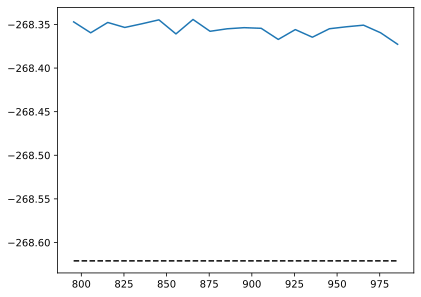

In [3]:
E_QMC = -268.62107

energy = qtx.utils.DataTracer()

for i in range(1000):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * 2e-3)
    energy.append(optimizer.energy)

    if i % 10 == 0:
        clear_output()
        energy.plot(start=-200, batch=10, baseline=E_QMC)
        plt.show()

The relative error of variational accuracy, given by

$$
\epsilon_\mathrm{rel} = (E_\mathrm{NQS} - E_\mathrm{QMC}) / |E_\mathrm{QMC}|,
$$

is similar to the $10^{-3}$ result presented in Fig. 3(C) of the original paper

In [4]:
E = energy[-100:].mean()
rel_err = (E - E_QMC) / abs(E_QMC)
print(rel_err)

0.0009721019350138251


Here we reproduce Fig. 2 of the original paper, which shows the weights in RBM.
The scale looks different due to training details, but the patterns are similar.

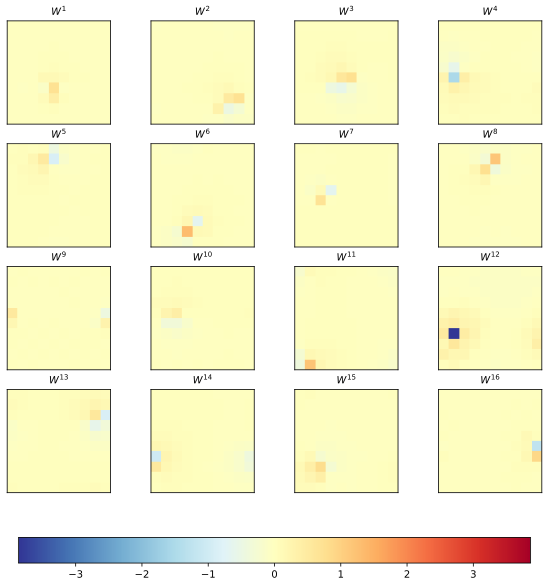

In [5]:
import jax.numpy as jnp
from matplotlib.colors import TwoSlopeNorm

W = state.model.layers[1].weight

# single symmetric color scale (centered at 0)
v = jnp.max(jnp.abs(W))
norm = TwoSlopeNorm(vmin=-v, vcenter=0.0, vmax=v)

fig, axes = plt.subplots(4, 4, figsize=(8, 8), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(W[i, 0], cmap='RdYlBu_r', norm=norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(rf'$W^{({i+1})}$', fontsize=10, fontstyle='italic')

# one horizontal colorbar under all panels
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.08, shrink=0.9)

plt.show()